# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

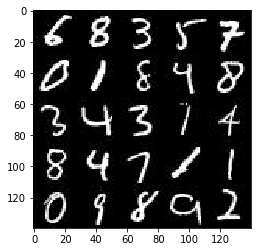

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

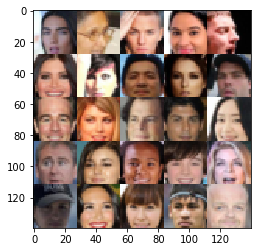

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer()) # Use xavier initializer
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Conv layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Conv layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flat layer
        unit_num = relu3.get_shape()[1] * relu3.get_shape()[2] * relu3.get_shape()[3]
        flat = tf.reshape(relu3, (-1, int(unit_num)))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # Fully-connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Conv_t layer
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.image.resize_nearest_neighbor(x2, (7, 7))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        # Conv_t layer
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        
        # Logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, 
                                            padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Output
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_Rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_num = 10
    show_num = 100
    
    show_images_num = 36
    
    # Get images information
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
        
    # Get inputs
    inputs_real, inputs_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Get losses
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # Get optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_Rate, beta1)
    
    saver = tf.train.Saver()
    
    ii = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                ii += 1
                
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learning_rate: learning_Rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, 
                                                     inputs_z: batch_z,
                                                     learning_rate: learning_Rate})
                
                if ii % print_num == 0:
                    # At losses
                    d_cost = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    g_cost = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch: {}/{} |".format(epoch_i+1, epoch_count),
                          "Steps: {:>4} |".format(ii),
                          "Discriminator Loss: {:.4f} |".format(d_cost),
                          "Generator Loss: {:.4f}".format(g_cost))
                
                if ii % show_num == 0:
                    show_generator_output(sess, 
                                          show_images_num, 
                                          inputs_z, 
                                          image_channels, 
                                          data_image_mode)
            
        saver.save(sess, './checkpoints/generator.ckpt')          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2 | Steps:   10 | Discriminator Loss: 0.9006 | Generator Loss: 0.9902
Epoch: 1/2 | Steps:   20 | Discriminator Loss: 0.5480 | Generator Loss: 5.5079
Epoch: 1/2 | Steps:   30 | Discriminator Loss: 3.9272 | Generator Loss: 0.0523
Epoch: 1/2 | Steps:   40 | Discriminator Loss: 2.6728 | Generator Loss: 0.1878
Epoch: 1/2 | Steps:   50 | Discriminator Loss: 1.0099 | Generator Loss: 0.9675
Epoch: 1/2 | Steps:   60 | Discriminator Loss: 1.3197 | Generator Loss: 0.5805
Epoch: 1/2 | Steps:   70 | Discriminator Loss: 1.4004 | Generator Loss: 0.5050
Epoch: 1/2 | Steps:   80 | Discriminator Loss: 0.9877 | Generator Loss: 0.9673
Epoch: 1/2 | Steps:   90 | Discriminator Loss: 1.6454 | Generator Loss: 3.1590
Epoch: 1/2 | Steps:  100 | Discriminator Loss: 1.1796 | Generator Loss: 2.4901


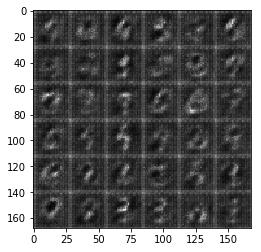

Epoch: 1/2 | Steps:  110 | Discriminator Loss: 1.1090 | Generator Loss: 2.5149
Epoch: 1/2 | Steps:  120 | Discriminator Loss: 1.1335 | Generator Loss: 2.2691
Epoch: 1/2 | Steps:  130 | Discriminator Loss: 1.0643 | Generator Loss: 2.7725
Epoch: 1/2 | Steps:  140 | Discriminator Loss: 0.8345 | Generator Loss: 2.6543
Epoch: 1/2 | Steps:  150 | Discriminator Loss: 1.1919 | Generator Loss: 3.5605
Epoch: 1/2 | Steps:  160 | Discriminator Loss: 0.5668 | Generator Loss: 2.9241
Epoch: 1/2 | Steps:  170 | Discriminator Loss: 0.4916 | Generator Loss: 2.3037
Epoch: 1/2 | Steps:  180 | Discriminator Loss: 0.5413 | Generator Loss: 2.9570
Epoch: 1/2 | Steps:  190 | Discriminator Loss: 0.4985 | Generator Loss: 2.2703
Epoch: 1/2 | Steps:  200 | Discriminator Loss: 0.3998 | Generator Loss: 3.2042


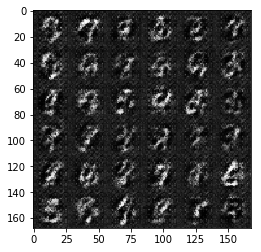

Epoch: 1/2 | Steps:  210 | Discriminator Loss: 0.4919 | Generator Loss: 2.0268
Epoch: 1/2 | Steps:  220 | Discriminator Loss: 0.4377 | Generator Loss: 2.4875
Epoch: 1/2 | Steps:  230 | Discriminator Loss: 2.1609 | Generator Loss: 0.2414
Epoch: 1/2 | Steps:  240 | Discriminator Loss: 0.6590 | Generator Loss: 1.7695
Epoch: 1/2 | Steps:  250 | Discriminator Loss: 0.6791 | Generator Loss: 1.5007
Epoch: 1/2 | Steps:  260 | Discriminator Loss: 1.1281 | Generator Loss: 3.9015
Epoch: 1/2 | Steps:  270 | Discriminator Loss: 1.6324 | Generator Loss: 6.6106
Epoch: 1/2 | Steps:  280 | Discriminator Loss: 1.0084 | Generator Loss: 3.3757
Epoch: 1/2 | Steps:  290 | Discriminator Loss: 0.7181 | Generator Loss: 1.3047
Epoch: 1/2 | Steps:  300 | Discriminator Loss: 0.7456 | Generator Loss: 1.3163


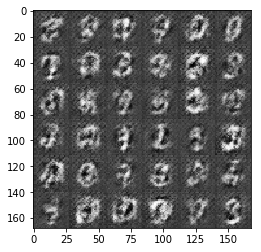

Epoch: 1/2 | Steps:  310 | Discriminator Loss: 0.6464 | Generator Loss: 1.8354
Epoch: 1/2 | Steps:  320 | Discriminator Loss: 1.0786 | Generator Loss: 0.7164
Epoch: 1/2 | Steps:  330 | Discriminator Loss: 0.9424 | Generator Loss: 0.8890
Epoch: 1/2 | Steps:  340 | Discriminator Loss: 1.1236 | Generator Loss: 0.6677
Epoch: 1/2 | Steps:  350 | Discriminator Loss: 0.6141 | Generator Loss: 1.5844
Epoch: 1/2 | Steps:  360 | Discriminator Loss: 0.6299 | Generator Loss: 1.5421
Epoch: 1/2 | Steps:  370 | Discriminator Loss: 0.6777 | Generator Loss: 1.3278
Epoch: 1/2 | Steps:  380 | Discriminator Loss: 0.6676 | Generator Loss: 1.5512
Epoch: 1/2 | Steps:  390 | Discriminator Loss: 0.5380 | Generator Loss: 2.2380
Epoch: 1/2 | Steps:  400 | Discriminator Loss: 0.7173 | Generator Loss: 1.8509


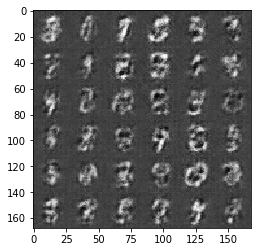

Epoch: 1/2 | Steps:  410 | Discriminator Loss: 0.5762 | Generator Loss: 1.7131
Epoch: 1/2 | Steps:  420 | Discriminator Loss: 0.7058 | Generator Loss: 1.3421
Epoch: 1/2 | Steps:  430 | Discriminator Loss: 0.6410 | Generator Loss: 1.4296
Epoch: 1/2 | Steps:  440 | Discriminator Loss: 0.5301 | Generator Loss: 1.9815
Epoch: 1/2 | Steps:  450 | Discriminator Loss: 0.7994 | Generator Loss: 1.0852
Epoch: 1/2 | Steps:  460 | Discriminator Loss: 0.8311 | Generator Loss: 1.0519
Epoch: 2/2 | Steps:  470 | Discriminator Loss: 0.5127 | Generator Loss: 2.0026
Epoch: 2/2 | Steps:  480 | Discriminator Loss: 0.8659 | Generator Loss: 1.0131
Epoch: 2/2 | Steps:  490 | Discriminator Loss: 0.4915 | Generator Loss: 2.3932
Epoch: 2/2 | Steps:  500 | Discriminator Loss: 0.5086 | Generator Loss: 2.0712


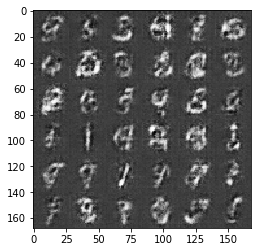

Epoch: 2/2 | Steps:  510 | Discriminator Loss: 0.4760 | Generator Loss: 2.2765
Epoch: 2/2 | Steps:  520 | Discriminator Loss: 0.4739 | Generator Loss: 2.2151
Epoch: 2/2 | Steps:  530 | Discriminator Loss: 1.7652 | Generator Loss: 5.0698
Epoch: 2/2 | Steps:  540 | Discriminator Loss: 0.5100 | Generator Loss: 2.0957
Epoch: 2/2 | Steps:  550 | Discriminator Loss: 0.4519 | Generator Loss: 2.8078
Epoch: 2/2 | Steps:  560 | Discriminator Loss: 0.6055 | Generator Loss: 4.0431
Epoch: 2/2 | Steps:  570 | Discriminator Loss: 0.5470 | Generator Loss: 1.7947
Epoch: 2/2 | Steps:  580 | Discriminator Loss: 0.5235 | Generator Loss: 1.9366
Epoch: 2/2 | Steps:  590 | Discriminator Loss: 0.4692 | Generator Loss: 2.2457
Epoch: 2/2 | Steps:  600 | Discriminator Loss: 0.5869 | Generator Loss: 1.6327


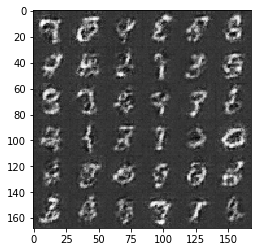

Epoch: 2/2 | Steps:  610 | Discriminator Loss: 1.1147 | Generator Loss: 0.7308
Epoch: 2/2 | Steps:  620 | Discriminator Loss: 0.5913 | Generator Loss: 2.0170
Epoch: 2/2 | Steps:  630 | Discriminator Loss: 0.4944 | Generator Loss: 2.0952
Epoch: 2/2 | Steps:  640 | Discriminator Loss: 0.4600 | Generator Loss: 2.2777
Epoch: 2/2 | Steps:  650 | Discriminator Loss: 0.4141 | Generator Loss: 3.3857
Epoch: 2/2 | Steps:  660 | Discriminator Loss: 0.4307 | Generator Loss: 2.6617
Epoch: 2/2 | Steps:  670 | Discriminator Loss: 0.4410 | Generator Loss: 2.4370
Epoch: 2/2 | Steps:  680 | Discriminator Loss: 0.5357 | Generator Loss: 1.8422
Epoch: 2/2 | Steps:  690 | Discriminator Loss: 1.1038 | Generator Loss: 0.7994
Epoch: 2/2 | Steps:  700 | Discriminator Loss: 0.6825 | Generator Loss: 1.4287


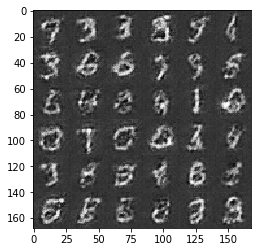

Epoch: 2/2 | Steps:  710 | Discriminator Loss: 0.6621 | Generator Loss: 1.3912
Epoch: 2/2 | Steps:  720 | Discriminator Loss: 0.4552 | Generator Loss: 2.6618
Epoch: 2/2 | Steps:  730 | Discriminator Loss: 0.4595 | Generator Loss: 2.2907
Epoch: 2/2 | Steps:  740 | Discriminator Loss: 0.4383 | Generator Loss: 2.5405
Epoch: 2/2 | Steps:  750 | Discriminator Loss: 0.4364 | Generator Loss: 2.4809
Epoch: 2/2 | Steps:  760 | Discriminator Loss: 0.4070 | Generator Loss: 3.0040
Epoch: 2/2 | Steps:  770 | Discriminator Loss: 0.4443 | Generator Loss: 2.4079
Epoch: 2/2 | Steps:  780 | Discriminator Loss: 0.6406 | Generator Loss: 1.5035
Epoch: 2/2 | Steps:  790 | Discriminator Loss: 1.7690 | Generator Loss: 0.3558
Epoch: 2/2 | Steps:  800 | Discriminator Loss: 0.8994 | Generator Loss: 1.0178


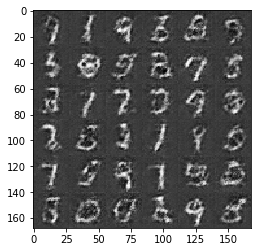

Epoch: 2/2 | Steps:  810 | Discriminator Loss: 0.6095 | Generator Loss: 1.6762
Epoch: 2/2 | Steps:  820 | Discriminator Loss: 0.5617 | Generator Loss: 1.7634
Epoch: 2/2 | Steps:  830 | Discriminator Loss: 0.4650 | Generator Loss: 2.4952
Epoch: 2/2 | Steps:  840 | Discriminator Loss: 0.4269 | Generator Loss: 2.7918
Epoch: 2/2 | Steps:  850 | Discriminator Loss: 0.4300 | Generator Loss: 2.6029
Epoch: 2/2 | Steps:  860 | Discriminator Loss: 0.3882 | Generator Loss: 3.5941
Epoch: 2/2 | Steps:  870 | Discriminator Loss: 0.6312 | Generator Loss: 4.8388
Epoch: 2/2 | Steps:  880 | Discriminator Loss: 0.4075 | Generator Loss: 2.8641
Epoch: 2/2 | Steps:  890 | Discriminator Loss: 0.3996 | Generator Loss: 3.0998
Epoch: 2/2 | Steps:  900 | Discriminator Loss: 0.3955 | Generator Loss: 3.0421


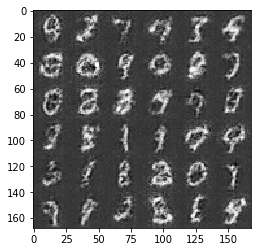

Epoch: 2/2 | Steps:  910 | Discriminator Loss: 0.3897 | Generator Loss: 3.7313
Epoch: 2/2 | Steps:  920 | Discriminator Loss: 0.5636 | Generator Loss: 1.8444
Epoch: 2/2 | Steps:  930 | Discriminator Loss: 0.3773 | Generator Loss: 3.2829


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1 | Steps:   10 | Discriminator Loss: 1.6763 | Generator Loss: 0.5196
Epoch: 1/1 | Steps:   20 | Discriminator Loss: 1.1290 | Generator Loss: 0.9767
Epoch: 1/1 | Steps:   30 | Discriminator Loss: 0.9658 | Generator Loss: 1.1732
Epoch: 1/1 | Steps:   40 | Discriminator Loss: 0.7319 | Generator Loss: 1.7486
Epoch: 1/1 | Steps:   50 | Discriminator Loss: 0.6101 | Generator Loss: 1.9811
Epoch: 1/1 | Steps:   60 | Discriminator Loss: 0.6244 | Generator Loss: 2.7161
Epoch: 1/1 | Steps:   70 | Discriminator Loss: 0.8044 | Generator Loss: 1.2275
Epoch: 1/1 | Steps:   80 | Discriminator Loss: 1.9383 | Generator Loss: 0.2827
Epoch: 1/1 | Steps:   90 | Discriminator Loss: 1.0920 | Generator Loss: 0.9274
Epoch: 1/1 | Steps:  100 | Discriminator Loss: 1.1052 | Generator Loss: 0.8121


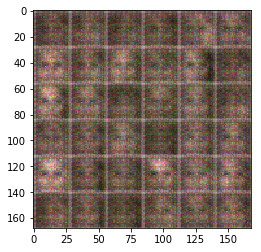

Epoch: 1/1 | Steps:  110 | Discriminator Loss: 0.8253 | Generator Loss: 1.7042
Epoch: 1/1 | Steps:  120 | Discriminator Loss: 1.0233 | Generator Loss: 1.1071
Epoch: 1/1 | Steps:  130 | Discriminator Loss: 0.8040 | Generator Loss: 2.0375
Epoch: 1/1 | Steps:  140 | Discriminator Loss: 0.6706 | Generator Loss: 2.0646
Epoch: 1/1 | Steps:  150 | Discriminator Loss: 0.9362 | Generator Loss: 3.6056
Epoch: 1/1 | Steps:  160 | Discriminator Loss: 0.7275 | Generator Loss: 3.2944
Epoch: 1/1 | Steps:  170 | Discriminator Loss: 0.8716 | Generator Loss: 1.0281
Epoch: 1/1 | Steps:  180 | Discriminator Loss: 0.9707 | Generator Loss: 3.8952
Epoch: 1/1 | Steps:  190 | Discriminator Loss: 1.0029 | Generator Loss: 4.4730
Epoch: 1/1 | Steps:  200 | Discriminator Loss: 0.6145 | Generator Loss: 4.6658


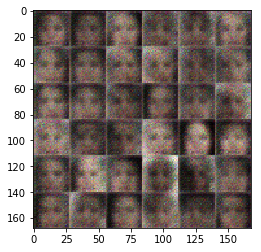

Epoch: 1/1 | Steps:  210 | Discriminator Loss: 0.5609 | Generator Loss: 3.8969
Epoch: 1/1 | Steps:  220 | Discriminator Loss: 0.4747 | Generator Loss: 2.4620
Epoch: 1/1 | Steps:  230 | Discriminator Loss: 0.7237 | Generator Loss: 4.3843
Epoch: 1/1 | Steps:  240 | Discriminator Loss: 0.7272 | Generator Loss: 4.7874
Epoch: 1/1 | Steps:  250 | Discriminator Loss: 1.5298 | Generator Loss: 0.3950
Epoch: 1/1 | Steps:  260 | Discriminator Loss: 0.6261 | Generator Loss: 1.5323
Epoch: 1/1 | Steps:  270 | Discriminator Loss: 1.2709 | Generator Loss: 0.5394
Epoch: 1/1 | Steps:  280 | Discriminator Loss: 1.1177 | Generator Loss: 5.5077
Epoch: 1/1 | Steps:  290 | Discriminator Loss: 0.3996 | Generator Loss: 4.3670
Epoch: 1/1 | Steps:  300 | Discriminator Loss: 1.6370 | Generator Loss: 0.3519


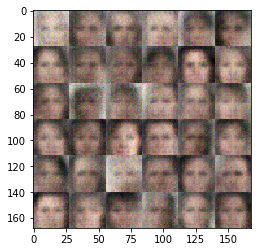

Epoch: 1/1 | Steps:  310 | Discriminator Loss: 0.4907 | Generator Loss: 2.1788
Epoch: 1/1 | Steps:  320 | Discriminator Loss: 1.1618 | Generator Loss: 0.7064
Epoch: 1/1 | Steps:  330 | Discriminator Loss: 1.4479 | Generator Loss: 8.1243
Epoch: 1/1 | Steps:  340 | Discriminator Loss: 0.4009 | Generator Loss: 4.1066
Epoch: 1/1 | Steps:  350 | Discriminator Loss: 0.4467 | Generator Loss: 4.9020
Epoch: 1/1 | Steps:  360 | Discriminator Loss: 0.4746 | Generator Loss: 2.2601
Epoch: 1/1 | Steps:  370 | Discriminator Loss: 0.4115 | Generator Loss: 3.6626
Epoch: 1/1 | Steps:  380 | Discriminator Loss: 0.5239 | Generator Loss: 3.9565
Epoch: 1/1 | Steps:  390 | Discriminator Loss: 0.7639 | Generator Loss: 6.7296
Epoch: 1/1 | Steps:  400 | Discriminator Loss: 0.6272 | Generator Loss: 6.3381


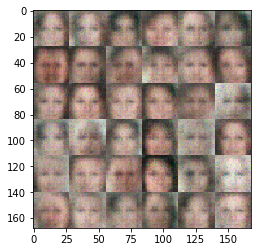

Epoch: 1/1 | Steps:  410 | Discriminator Loss: 0.4559 | Generator Loss: 2.4293
Epoch: 1/1 | Steps:  420 | Discriminator Loss: 2.1026 | Generator Loss: 0.2435
Epoch: 1/1 | Steps:  430 | Discriminator Loss: 1.5930 | Generator Loss: 7.4019
Epoch: 1/1 | Steps:  440 | Discriminator Loss: 0.3708 | Generator Loss: 4.0560
Epoch: 1/1 | Steps:  450 | Discriminator Loss: 0.4668 | Generator Loss: 2.2647
Epoch: 1/1 | Steps:  460 | Discriminator Loss: 0.9018 | Generator Loss: 1.0149
Epoch: 1/1 | Steps:  470 | Discriminator Loss: 0.7353 | Generator Loss: 9.2291
Epoch: 1/1 | Steps:  480 | Discriminator Loss: 0.3697 | Generator Loss: 3.7110
Epoch: 1/1 | Steps:  490 | Discriminator Loss: 0.4812 | Generator Loss: 2.8556
Epoch: 1/1 | Steps:  500 | Discriminator Loss: 1.9476 | Generator Loss: 0.2392


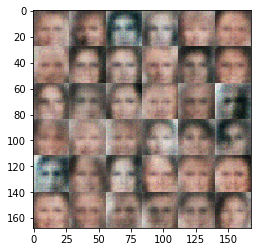

Epoch: 1/1 | Steps:  510 | Discriminator Loss: 1.2119 | Generator Loss: 9.4684
Epoch: 1/1 | Steps:  520 | Discriminator Loss: 0.6560 | Generator Loss: 1.3577
Epoch: 1/1 | Steps:  530 | Discriminator Loss: 0.5511 | Generator Loss: 1.7769
Epoch: 1/1 | Steps:  540 | Discriminator Loss: 0.4185 | Generator Loss: 4.1645
Epoch: 1/1 | Steps:  550 | Discriminator Loss: 0.7256 | Generator Loss: 3.3783
Epoch: 1/1 | Steps:  560 | Discriminator Loss: 0.9831 | Generator Loss: 0.7841
Epoch: 1/1 | Steps:  570 | Discriminator Loss: 1.6175 | Generator Loss: 8.7442
Epoch: 1/1 | Steps:  580 | Discriminator Loss: 0.3924 | Generator Loss: 3.2795
Epoch: 1/1 | Steps:  590 | Discriminator Loss: 0.6137 | Generator Loss: 8.1043
Epoch: 1/1 | Steps:  600 | Discriminator Loss: 0.6376 | Generator Loss: 9.4110


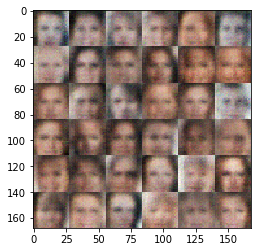

Epoch: 1/1 | Steps:  610 | Discriminator Loss: 0.3463 | Generator Loss: 6.1343
Epoch: 1/1 | Steps:  620 | Discriminator Loss: 0.4322 | Generator Loss: 2.7795
Epoch: 1/1 | Steps:  630 | Discriminator Loss: 1.2208 | Generator Loss: 0.5706
Epoch: 1/1 | Steps:  640 | Discriminator Loss: 0.3413 | Generator Loss: 5.6713
Epoch: 1/1 | Steps:  650 | Discriminator Loss: 0.3730 | Generator Loss: 3.4499
Epoch: 1/1 | Steps:  660 | Discriminator Loss: 1.4438 | Generator Loss: 0.4447
Epoch: 1/1 | Steps:  670 | Discriminator Loss: 0.3863 | Generator Loss: 7.6594
Epoch: 1/1 | Steps:  680 | Discriminator Loss: 1.2266 | Generator Loss: 0.5698
Epoch: 1/1 | Steps:  690 | Discriminator Loss: 1.5413 | Generator Loss: 0.3839
Epoch: 1/1 | Steps:  700 | Discriminator Loss: 0.4844 | Generator Loss: 2.1347


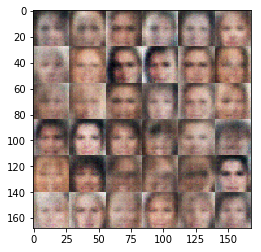

Epoch: 1/1 | Steps:  710 | Discriminator Loss: 0.3384 | Generator Loss: 7.6791
Epoch: 1/1 | Steps:  720 | Discriminator Loss: 0.4793 | Generator Loss: 2.5309
Epoch: 1/1 | Steps:  730 | Discriminator Loss: 0.3914 | Generator Loss: 3.0301
Epoch: 1/1 | Steps:  740 | Discriminator Loss: 0.9619 | Generator Loss: 6.5342
Epoch: 1/1 | Steps:  750 | Discriminator Loss: 0.4025 | Generator Loss: 8.9630
Epoch: 1/1 | Steps:  760 | Discriminator Loss: 0.3676 | Generator Loss: 6.9570
Epoch: 1/1 | Steps:  770 | Discriminator Loss: 0.3485 | Generator Loss: 5.8723
Epoch: 1/1 | Steps:  780 | Discriminator Loss: 0.4447 | Generator Loss: 9.0534
Epoch: 1/1 | Steps:  790 | Discriminator Loss: 0.5769 | Generator Loss: 2.0025
Epoch: 1/1 | Steps:  800 | Discriminator Loss: 0.3667 | Generator Loss: 4.1723


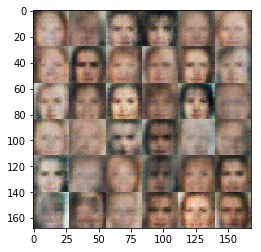

Epoch: 1/1 | Steps:  810 | Discriminator Loss: 1.0767 | Generator Loss: 0.7088
Epoch: 1/1 | Steps:  820 | Discriminator Loss: 0.7064 | Generator Loss: 1.3827
Epoch: 1/1 | Steps:  830 | Discriminator Loss: 1.0590 | Generator Loss: 0.7162
Epoch: 1/1 | Steps:  840 | Discriminator Loss: 0.9573 | Generator Loss: 0.8317
Epoch: 1/1 | Steps:  850 | Discriminator Loss: 0.3872 | Generator Loss: 7.4069
Epoch: 1/1 | Steps:  860 | Discriminator Loss: 0.7650 | Generator Loss: 1.2737
Epoch: 1/1 | Steps:  870 | Discriminator Loss: 0.7651 | Generator Loss: 7.1293
Epoch: 1/1 | Steps:  880 | Discriminator Loss: 0.4385 | Generator Loss: 3.1860
Epoch: 1/1 | Steps:  890 | Discriminator Loss: 0.4568 | Generator Loss: 7.2385
Epoch: 1/1 | Steps:  900 | Discriminator Loss: 0.3605 | Generator Loss: 6.7263


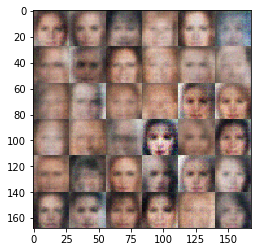

Epoch: 1/1 | Steps:  910 | Discriminator Loss: 0.3826 | Generator Loss: 5.1316
Epoch: 1/1 | Steps:  920 | Discriminator Loss: 0.4006 | Generator Loss: 4.5409
Epoch: 1/1 | Steps:  930 | Discriminator Loss: 0.4030 | Generator Loss: 3.4110
Epoch: 1/1 | Steps:  940 | Discriminator Loss: 1.2477 | Generator Loss: 7.1770
Epoch: 1/1 | Steps:  950 | Discriminator Loss: 0.7530 | Generator Loss: 1.2709
Epoch: 1/1 | Steps:  960 | Discriminator Loss: 0.3431 | Generator Loss: 7.9161
Epoch: 1/1 | Steps:  970 | Discriminator Loss: 0.5045 | Generator Loss: 2.4115
Epoch: 1/1 | Steps:  980 | Discriminator Loss: 0.3989 | Generator Loss: 4.2302
Epoch: 1/1 | Steps:  990 | Discriminator Loss: 0.5072 | Generator Loss: 2.4169
Epoch: 1/1 | Steps: 1000 | Discriminator Loss: 0.4502 | Generator Loss: 4.9965


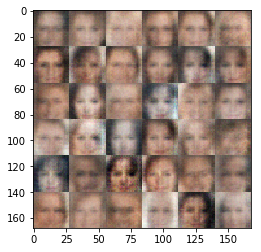

Epoch: 1/1 | Steps: 1010 | Discriminator Loss: 0.4620 | Generator Loss: 2.6265
Epoch: 1/1 | Steps: 1020 | Discriminator Loss: 0.3914 | Generator Loss: 4.3965
Epoch: 1/1 | Steps: 1030 | Discriminator Loss: 0.4841 | Generator Loss: 4.1644
Epoch: 1/1 | Steps: 1040 | Discriminator Loss: 0.9351 | Generator Loss: 5.6882
Epoch: 1/1 | Steps: 1050 | Discriminator Loss: 0.4272 | Generator Loss: 6.2598
Epoch: 1/1 | Steps: 1060 | Discriminator Loss: 0.4321 | Generator Loss: 3.4719
Epoch: 1/1 | Steps: 1070 | Discriminator Loss: 0.6388 | Generator Loss: 6.0557
Epoch: 1/1 | Steps: 1080 | Discriminator Loss: 0.3696 | Generator Loss: 3.9888
Epoch: 1/1 | Steps: 1090 | Discriminator Loss: 1.4507 | Generator Loss: 7.7354
Epoch: 1/1 | Steps: 1100 | Discriminator Loss: 0.5507 | Generator Loss: 6.1368


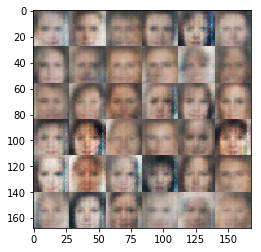

Epoch: 1/1 | Steps: 1110 | Discriminator Loss: 1.0388 | Generator Loss: 0.7581
Epoch: 1/1 | Steps: 1120 | Discriminator Loss: 0.7957 | Generator Loss: 1.1103
Epoch: 1/1 | Steps: 1130 | Discriminator Loss: 0.4166 | Generator Loss: 3.0167
Epoch: 1/1 | Steps: 1140 | Discriminator Loss: 0.4283 | Generator Loss: 2.8569
Epoch: 1/1 | Steps: 1150 | Discriminator Loss: 0.4020 | Generator Loss: 3.1709
Epoch: 1/1 | Steps: 1160 | Discriminator Loss: 0.4502 | Generator Loss: 2.5767
Epoch: 1/1 | Steps: 1170 | Discriminator Loss: 1.0349 | Generator Loss: 0.7393
Epoch: 1/1 | Steps: 1180 | Discriminator Loss: 2.7164 | Generator Loss: 0.1268
Epoch: 1/1 | Steps: 1190 | Discriminator Loss: 0.8493 | Generator Loss: 1.0451
Epoch: 1/1 | Steps: 1200 | Discriminator Loss: 0.7625 | Generator Loss: 1.2530


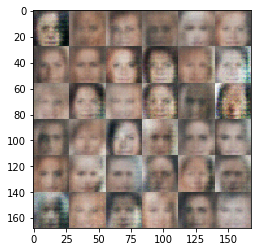

Epoch: 1/1 | Steps: 1210 | Discriminator Loss: 0.4709 | Generator Loss: 2.3415
Epoch: 1/1 | Steps: 1220 | Discriminator Loss: 0.3888 | Generator Loss: 4.2863
Epoch: 1/1 | Steps: 1230 | Discriminator Loss: 0.3787 | Generator Loss: 5.0321
Epoch: 1/1 | Steps: 1240 | Discriminator Loss: 0.7598 | Generator Loss: 6.7490
Epoch: 1/1 | Steps: 1250 | Discriminator Loss: 0.5658 | Generator Loss: 1.7551
Epoch: 1/1 | Steps: 1260 | Discriminator Loss: 0.8736 | Generator Loss: 6.0517
Epoch: 1/1 | Steps: 1270 | Discriminator Loss: 0.4716 | Generator Loss: 6.3931
Epoch: 1/1 | Steps: 1280 | Discriminator Loss: 0.3437 | Generator Loss: 6.5311
Epoch: 1/1 | Steps: 1290 | Discriminator Loss: 0.8514 | Generator Loss: 7.3120
Epoch: 1/1 | Steps: 1300 | Discriminator Loss: 0.3452 | Generator Loss: 6.2138


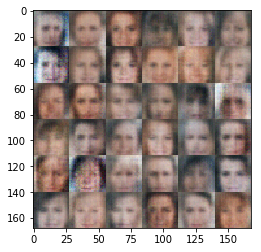

Epoch: 1/1 | Steps: 1310 | Discriminator Loss: 0.7355 | Generator Loss: 5.1411
Epoch: 1/1 | Steps: 1320 | Discriminator Loss: 0.4481 | Generator Loss: 5.9734
Epoch: 1/1 | Steps: 1330 | Discriminator Loss: 0.3604 | Generator Loss: 6.8073
Epoch: 1/1 | Steps: 1340 | Discriminator Loss: 0.7601 | Generator Loss: 1.1405
Epoch: 1/1 | Steps: 1350 | Discriminator Loss: 0.8050 | Generator Loss: 1.0386
Epoch: 1/1 | Steps: 1360 | Discriminator Loss: 0.3862 | Generator Loss: 3.2936
Epoch: 1/1 | Steps: 1370 | Discriminator Loss: 0.3731 | Generator Loss: 3.7571
Epoch: 1/1 | Steps: 1380 | Discriminator Loss: 1.0308 | Generator Loss: 6.2986
Epoch: 1/1 | Steps: 1390 | Discriminator Loss: 1.2653 | Generator Loss: 0.6513
Epoch: 1/1 | Steps: 1400 | Discriminator Loss: 1.3084 | Generator Loss: 5.5702


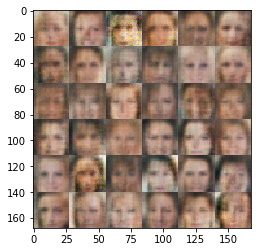

Epoch: 1/1 | Steps: 1410 | Discriminator Loss: 0.3489 | Generator Loss: 5.6752
Epoch: 1/1 | Steps: 1420 | Discriminator Loss: 0.3803 | Generator Loss: 5.7196
Epoch: 1/1 | Steps: 1430 | Discriminator Loss: 0.5027 | Generator Loss: 5.9955
Epoch: 1/1 | Steps: 1440 | Discriminator Loss: 0.3730 | Generator Loss: 4.3409
Epoch: 1/1 | Steps: 1450 | Discriminator Loss: 0.4330 | Generator Loss: 2.7179
Epoch: 1/1 | Steps: 1460 | Discriminator Loss: 0.5087 | Generator Loss: 6.9045
Epoch: 1/1 | Steps: 1470 | Discriminator Loss: 0.3680 | Generator Loss: 6.9889
Epoch: 1/1 | Steps: 1480 | Discriminator Loss: 0.3455 | Generator Loss: 5.3912
Epoch: 1/1 | Steps: 1490 | Discriminator Loss: 0.4682 | Generator Loss: 2.2764
Epoch: 1/1 | Steps: 1500 | Discriminator Loss: 0.3827 | Generator Loss: 3.3287


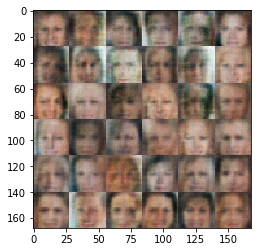

Epoch: 1/1 | Steps: 1510 | Discriminator Loss: 0.4797 | Generator Loss: 2.2307
Epoch: 1/1 | Steps: 1520 | Discriminator Loss: 0.3485 | Generator Loss: 4.6818
Epoch: 1/1 | Steps: 1530 | Discriminator Loss: 0.3505 | Generator Loss: 8.0398
Epoch: 1/1 | Steps: 1540 | Discriminator Loss: 0.4794 | Generator Loss: 2.3510
Epoch: 1/1 | Steps: 1550 | Discriminator Loss: 0.4556 | Generator Loss: 2.3483
Epoch: 1/1 | Steps: 1560 | Discriminator Loss: 0.4638 | Generator Loss: 2.4604
Epoch: 1/1 | Steps: 1570 | Discriminator Loss: 0.5655 | Generator Loss: 1.6762
Epoch: 1/1 | Steps: 1580 | Discriminator Loss: 0.4944 | Generator Loss: 6.5140


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.